In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  drive_path = './drive/MyDrive/'
else:
  drive_path = './'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/ArashSameni/rfml

Cloning into 'rfml'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 252 (delta 9), reused 13 (delta 5), pack-reused 228 (from 1)
Receiving objects: 100% (252/252), 17.46 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [3]:
!pip install --user -e ./rfml

Obtaining file:///content/rfml
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 7.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for setGPU: filename=setGPU-0.0.7-py3-none-any.whl size=1522 sha256=860fbdeb11b69f7e523b9714e33fd5c8ad189a8044368fac3e33fac91bd076d5
  Stored in directory: /root/.cache/pip/wheels/d7/2c/ad/81aecbf2335b0c49bd5eab58ebc55deec78e168482de7e2e38
  Created wheel for gpustat: filename=gpustat-1.1.1-py3-none-any.whl size=26536 sha256=5ec4a9740b3a45c6d68628ba3345c75844d0d42d080d6560c46c587ca9e91069
  Stored in directory: /root/.cache/pip/wheels/ec/d7/80/a71ba3540900e1f276bcae685efd8e590c810d2108b95f1e47
S

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Internal Includes
from rfml.nn.model import Model
from rfml.data import Dataset, Encoder
from rfml.data.converters import load_RML201610A_dataset
from rfml.nn.train import StandardTrainingStrategy, PrintingTrainingListener
from rfml.nbutils import plot_acc_vs_snr, plot_confusion, plot_IQ
from rfml.nn.eval import compute_accuracy, compute_accuracy_on_cross_sections, compute_confusion
from pandas import DataFrame

from typing import List
from pprint import pprint

In [3]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = drive_path + 'RML2016.10a_dict.pkl' # Set to a file path if you've downloaded RML2016.10A locally

In [5]:
dataset = load_RML201610A_dataset(path=data_path)
print(f'Dataset size: {len(dataset)}')
pprint(dataset.get_examples_per_class())

Dataset size: 220000
{'8PSK': 20000,
 'AM-DSB': 20000,
 'AM-SSB': 20000,
 'BPSK': 20000,
 'CPFSK': 20000,
 'GFSK': 20000,
 'PAM4': 20000,
 'QAM16': 20000,
 'QAM64': 20000,
 'QPSK': 20000,
 'WBFM': 20000}


In [6]:
print(f'Modulations: {dataset.metadata["Modulation"]}')
print(f'SNRs: {dataset.metadata["SNR"]}')

Modulations: {'AM-DSB', 'WBFM', 'PAM4', 'AM-SSB', 'GFSK', '8PSK', 'CPFSK', 'QAM16', 'QAM64', 'BPSK', 'QPSK'}
SNRs: {0, 2, 4, 6, 8, 10, 12, 14, 16, 18, -20, -18, -16, -14, -12, -10, -8, -6, -4, -2}


In [7]:
train, test = dataset.split(frac=0.5, on=["Modulation", "SNR"])

print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 10000,
 'AM-DSB': 10000,
 'AM-SSB': 10000,
 'BPSK': 10000,
 'CPFSK': 10000,
 'GFSK': 10000,
 'PAM4': 10000,
 'QAM16': 10000,
 'QAM64': 10000,
 'QPSK': 10000,
 'WBFM': 10000}

Testing Examples
{'8PSK': 10000,
 'AM-DSB': 10000,
 'AM-SSB': 10000,
 'BPSK': 10000,
 'CPFSK': 10000,
 'GFSK': 10000,
 'PAM4': 10000,
 'QAM16': 10000,
 'QAM64': 10000,
 'QPSK': 10000,
 'WBFM': 10000}


In [8]:
le = Encoder([
    '8PSK',
    'AM-DSB',
    'AM-SSB',
    'BPSK',
    'CPFSK',
    'GFSK',
    'PAM4',
    'QAM16',
    'QAM64',
    'QPSK',
    'WBFM'], label_name="Modulation")
print(le)

8PSK: 0
AM-DSB: 1
AM-SSB: 2
BPSK: 3
CPFSK: 4
GFSK: 5
PAM4: 6
QAM16: 7
QAM64: 8
QPSK: 9
WBFM: 10



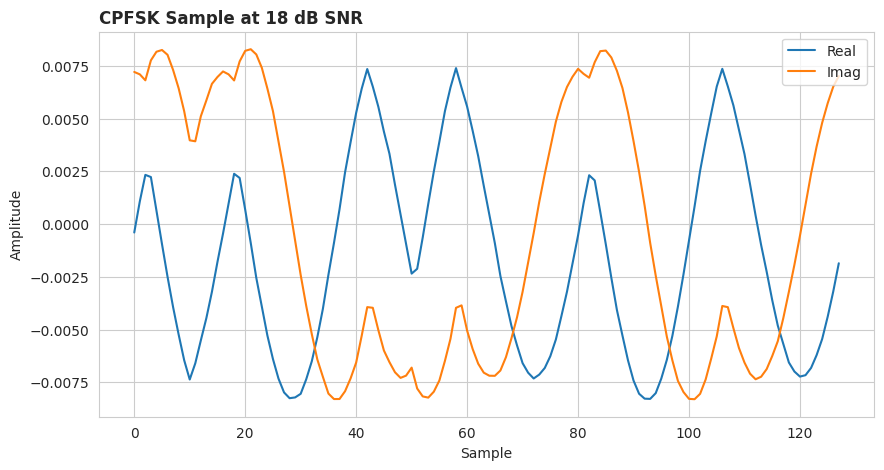

In [9]:
# Plot a sample of the data
# You can choose a different sample by changing
idx = 10
snr = 18
modulation = "CPFSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

In [10]:
class VT_CNN2(Model):
    def __init__(
        self,
        n_classes: int = 11,
        dropout: float = 0.5,
    ):
        super().__init__(input_samples=128, n_classes=n_classes)

        self.model = nn.Sequential(
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=1, out_channels=256, kernel_size=(1, 3), stride=1, padding=0, bias=False
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.ZeroPad2d(
                padding=(
                    2,
                    2,
                    0,
                    0,
                )
            ),  # zero pad front/back of each signal by 2
            nn.Conv2d(
                in_channels=256,
                out_channels=80,
                kernel_size=(2, 3),
                stride=1,
                padding=0,
            ),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Flatten(),
            nn.Linear(in_features=10560, out_features=256, bias=True),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=256, out_features=n_classes, bias=True),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
model = VT_CNN2()
if torch.cuda.is_available():
  model.cuda()

# Print model summary
print(model)

learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of Learnable Parameters: {learnable_params}')

VT_CNN2(
  (model): Sequential(
    (0): ZeroPad2d((2, 2, 0, 0))
    (1): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), bias=False)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): ZeroPad2d((2, 2, 0, 0))
    (5): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1))
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10560, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=11, bias=True)
  )
)
----------------------
Trainable Parameters: 2830171
Fixed Parameters: 0
Total Parameters: 2830171
----------------------

Number of Learnable Parameters: 2830171


In [12]:
lr = 1e-3           # learning rate
max_epochs = 100    # number of epochs to train on
batch_size = 1024   # training batch size
n_classes = 11      # number of classes
patience = 5        # patience of early stopping

training_listener = PrintingTrainingListener()

In [ ]:
trainer = StandardTrainingStrategy(lr, max_epochs, patience, batch_size, gpu=True)
trainer.register_listener(training_listener)

In [ ]:
trainer(model=model,
                               training=train,
                               validation=test,
                               le=le)
model.save(drive_path + 'VTCNN2_100Epochs.pt')

Epoch 0 completed!
		-Mean Training Loss: 2.131
		-Mean Validation Loss: 1.935
Epoch 1 completed!
		-Mean Training Loss: 1.899
		-Mean Validation Loss: 1.782
Epoch 2 completed!
		-Mean Training Loss: 1.766
		-Mean Validation Loss: 1.646
Epoch 3 completed!
		-Mean Training Loss: 1.675
		-Mean Validation Loss: 1.558
Epoch 4 completed!
		-Mean Training Loss: 1.609
		-Mean Validation Loss: 1.502
Epoch 5 completed!
		-Mean Training Loss: 1.553
		-Mean Validation Loss: 1.442
Epoch 6 completed!
		-Mean Training Loss: 1.514
		-Mean Validation Loss: 1.409
Epoch 7 completed!
		-Mean Training Loss: 1.483
		-Mean Validation Loss: 1.380
Epoch 8 completed!
		-Mean Training Loss: 1.461
		-Mean Validation Loss: 1.363
Epoch 9 completed!
		-Mean Training Loss: 1.441
		-Mean Validation Loss: 1.344
Epoch 10 completed!
		-Mean Training Loss: 1.422
		-Mean Validation Loss: 1.345
Epoch 11 completed!
		-Mean Training Loss: 1.411
		-Mean Validation Loss: 1.324
Epoch 12 completed!
		-Mean Training Loss: 1.397
	

TypeError: cannot unpack non-iterable NoneType object

In [13]:
model.load(drive_path + 'VTCNN2_100Epochs.pt')

/content/rfml/rfml/nn/model/base.py:218: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=map_location)


In [14]:
acc = compute_accuracy(model=model, data=test, le=le)
print("Overall Testing Accuracy: {:.2f}%".format(acc * 100))

Overall Testing Accuracy: 54.05%


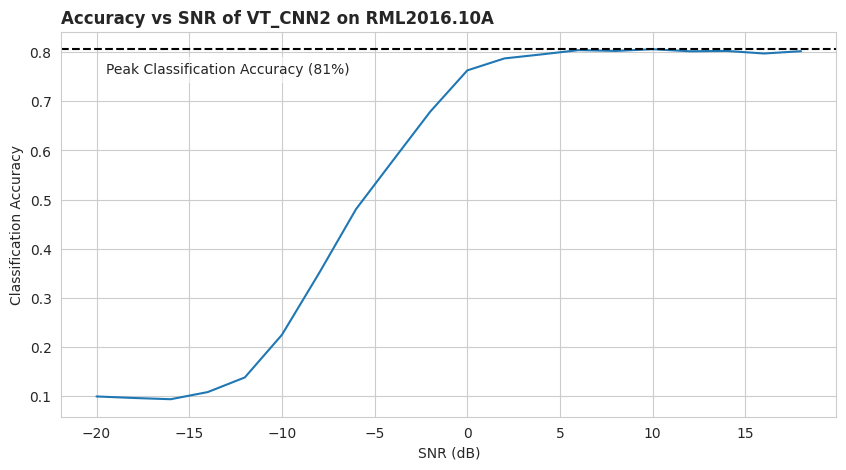


SNR: -20, Overall Accuracy: 9.91%
SNR: -18, Overall Accuracy: 9.60%
SNR: -16, Overall Accuracy: 9.35%
SNR: -14, Overall Accuracy: 10.80%
SNR: -12, Overall Accuracy: 13.78%
SNR: -10, Overall Accuracy: 22.45%
SNR: -8, Overall Accuracy: 34.98%
SNR: -6, Overall Accuracy: 48.05%
SNR: -4, Overall Accuracy: 58.00%
SNR: -2, Overall Accuracy: 67.89%
SNR: 0, Overall Accuracy: 76.29%
SNR: 2, Overall Accuracy: 78.73%
SNR: 4, Overall Accuracy: 79.55%
SNR: 6, Overall Accuracy: 80.42%
SNR: 8, Overall Accuracy: 80.25%
SNR: 10, Overall Accuracy: 80.60%
SNR: 12, Overall Accuracy: 80.18%
SNR: 14, Overall Accuracy: 80.25%
SNR: 16, Overall Accuracy: 79.73%
SNR: 18, Overall Accuracy: 80.20%


In [15]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="VT_CNN2", dataset_name="RML2016.10A")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

print()
for idx in np.argsort(snr):
    print("SNR: {}, Overall Accuracy: {:.2f}%".format(snr[idx], acc_vs_snr[idx] * 100))

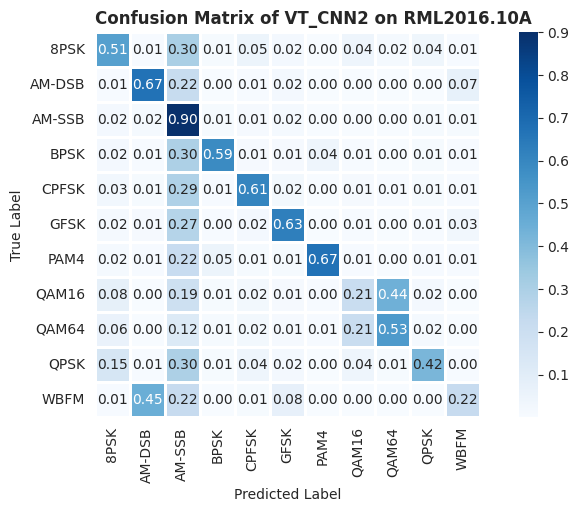

In [16]:
cmn = compute_confusion(model=model, data=test, le=le)

title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="VT_CNN2", dataset_name="RML2016.10A")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

# Attacks

In [15]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: reque

In [17]:
import torchattacks

In [18]:
pgd_atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
fgsm_atk = fgsm_atk = torchattacks.FGSM(model, eps=8/255)
deepfool_atk = torchattacks.DeepFool(model, steps=50, overshoot=0.02)

In [19]:
def compute_accuracy_after_atks(
    model: Model,
    data: Dataset,
    le: Encoder,
    atks: List[torchattacks.attack.Attack],
    batch_size: int = 512,
    mask: DataFrame.mask = None
):
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    total = 0
    corrects = {atk.__class__.__name__: 0 for atk in atks}
    corrects[model.__class__.__name__] = 0

    for batch, data in enumerate(dl):
        inputs, labels = data

        predictions = model.predict(inputs)
        corrects[model.__class__.__name__] += (predictions == labels).sum().item()
        total += len(labels)

        for atk in atks:
            adv_inputs = atk(inputs, labels)
            adv_predictions = model.predict(adv_inputs)
            corrects[atk.__class__.__name__] += (adv_predictions == labels).sum().item()

        print(f'Batch: {batch}, Total: {total}, Corrects: {corrects}')

    accuracies = {k: float(corrects[k]) / total for k in corrects}

    return accuracies

In [20]:
atks = [pgd_atk, fgsm_atk, deepfool_atk]
mask = (dataset.df["SNR"] == 18)
accuracies = compute_accuracy_after_atks(model, test, le, atks, mask=mask)

/content/rfml/rfml/data/dataset.py:237: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[mask]


Batch: 0, Total: 512, Corrects: {'PGD': 2, 'FGSM': 41, 'DeepFool': 5, 'VT_CNN2': 413}
Batch: 1, Total: 1024, Corrects: {'PGD': 2, 'FGSM': 85, 'DeepFool': 11, 'VT_CNN2': 818}
Batch: 2, Total: 1536, Corrects: {'PGD': 2, 'FGSM': 129, 'DeepFool': 14, 'VT_CNN2': 1220}
Batch: 3, Total: 2048, Corrects: {'PGD': 2, 'FGSM': 178, 'DeepFool': 21, 'VT_CNN2': 1626}
Batch: 4, Total: 2560, Corrects: {'PGD': 2, 'FGSM': 219, 'DeepFool': 24, 'VT_CNN2': 2024}
Batch: 5, Total: 3072, Corrects: {'PGD': 3, 'FGSM': 275, 'DeepFool': 32, 'VT_CNN2': 2444}
Batch: 6, Total: 3584, Corrects: {'PGD': 3, 'FGSM': 312, 'DeepFool': 34, 'VT_CNN2': 2852}
Batch: 7, Total: 4096, Corrects: {'PGD': 4, 'FGSM': 336, 'DeepFool': 42, 'VT_CNN2': 3277}
Batch: 8, Total: 4608, Corrects: {'PGD': 4, 'FGSM': 380, 'DeepFool': 45, 'VT_CNN2': 3679}
Batch: 9, Total: 5120, Corrects: {'PGD': 4, 'FGSM': 421, 'DeepFool': 49, 'VT_CNN2': 4101}
Batch: 10, Total: 5500, Corrects: {'PGD': 4, 'FGSM': 441, 'DeepFool': 53, 'VT_CNN2': 4411}


In [21]:
for k in accuracies:
    print(f'{k}: {accuracies[k] * 100}%')

PGD: 0.07272727272727272%
FGSM: 8.01818181818182%
DeepFool: 0.9636363636363635%
VT_CNN2: 80.2%


# Denoising Diffusion Probabilistic Model

In [9]:
!pip install denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.2 MB/s eta 0:00:00


In [22]:
mask = (dataset.df["SNR"] == 18)
tensor_dataset = dataset.as_torch(le, mask)
training_seq = torch.squeeze(tensor_dataset.tensors[0])

# Normalize the features from 0 to 1
min_val = training_seq.min(dim=0, keepdim=True).values
max_val = training_seq.max(dim=0, keepdim=True).values
training_seq = (training_seq - min_val) / (max_val - min_val)
training_seq

tensor([[[0.6580, 0.5493, 0.5514,  ..., 0.4811, 0.3556, 0.3920],
         [0.5576, 0.5264, 0.5519,  ..., 0.3301, 0.2471, 0.2365]],

        [[0.3764, 0.2804, 0.3614,  ..., 0.4974, 0.3402, 0.3369],
         [0.5960, 0.5964, 0.6544,  ..., 0.4391, 0.3410, 0.3127]],

        [[0.5283, 0.4150, 0.4401,  ..., 0.5017, 0.3905, 0.4346],
         [0.3155, 0.3221, 0.4137,  ..., 0.3485, 0.2590, 0.2439]],

        ...,

        [[0.5813, 0.4976, 0.5357,  ..., 0.4882, 0.3510, 0.3734],
         [0.3081, 0.3075, 0.3908,  ..., 0.3389, 0.2530, 0.2389]],

        [[0.5819, 0.4993, 0.5358,  ..., 0.4888, 0.3522, 0.3734],
         [0.3098, 0.3108, 0.3910,  ..., 0.3383, 0.2532, 0.2389]],

        [[0.5815, 0.4981, 0.5347,  ..., 0.4889, 0.3512, 0.3735],
         [0.3094, 0.3120, 0.3922,  ..., 0.3386, 0.2534, 0.2391]]])

In [23]:
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

diffusion_model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 2
)

diffusion = GaussianDiffusion1D(
    diffusion_model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_v'
)

if torch.cuda.is_available():
  diffusion_model.cuda()
  diffusion.cuda()

diffusion_dataset = Dataset1D(training_seq)

trainer = Trainer1D(
    diffusion,
    dataset = diffusion_dataset,
    train_batch_size = 128,
    train_lr = 8e-5,
    train_num_steps = 350000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = False,                       # turn on mixed precision
    save_and_sample_every = 35000,
    results_folder=drive_path + 'diffusion_results',
)

/usr/local/lib/python3.10/dist-packages/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py:775: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/usr/local/lib/python3.10/dist-packages/denoising_diffusion_pytorch/continuous_time_gaussian_diffusion.py:237: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/usr/local/lib/python3.10/dist-packages/denoising_diffusion_pytorch/v_param_continuous_time_gaussian_diffusion.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/usr/local/lib/python3.10/dist-packages/denoising_diffusion_pytorch/denoising_diffusion_pytorch_1d.py:663: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda',

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(split_batches=True)
  warnings.warn(


  0%|          | 0/350000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

training complete


In [24]:
trainer.load(10)

/usr/local/lib/python3.10/dist-packages/denoising_diffusion_pytorch/denoising_diffusion_pytorch_1d.py:818: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(st

loading from version 2.0.16


In [70]:
sample_idx = 0
sample_input = tensor_dataset[sample_idx][0].unsqueeze(0).to('cuda')
sample_label = tensor_dataset[sample_idx][1].unsqueeze(0).to('cuda')

pgd_atk = torchattacks.PGD(model, eps=8/255, alpha=2/225, steps=10, random_start=True)
sample_adv = pgd_atk(sample_input, sample_label)

print(f'True label: {sample_label[0]}, Prediction: {model.predict(sample_input)[0]}, Adv Prediction: {model.predict(sample_adv)[0]}')

True label: 0, Prediction: 0, Adv Prediction: 6


In [71]:
# normalize input
sample_adv_norm = (sample_adv - min_val.to('cuda')) / (max_val.to('cuda') - min_val.to('cuda'))
sample_adv_norm

tensor([[[[1.3799, 1.3484, 1.2773, 1.2382, 1.2130, 1.2858, 0.9951, 1.3312,
           0.9346, 0.9252, 1.3188, 1.3785, 1.3762, 1.4926, 0.9706, 1.4362,
           1.0621, 1.2496, 1.5167, 1.3386, 1.2722, 1.4806, 1.3379, 1.2933,
           1.2432, 1.0803, 1.2088, 0.9447, 0.9536, 1.0271, 1.0695, 1.0474,
           1.0451, 1.1037, 1.1891, 1.3617, 0.9744, 1.3514, 0.9294, 0.9796,
           1.3012, 1.1423, 1.1797, 1.3095, 1.4271, 1.3434, 1.4610, 1.4812,
           1.4538, 1.1880, 1.4624, 1.0885, 1.0844, 1.2834, 1.5185, 1.3749,
           1.4359, 1.1348, 1.2737, 1.1934, 1.1700, 1.0405, 0.9936, 1.0580,
           1.0615, 1.0195, 1.0530, 1.1191, 1.1164, 1.0683, 1.1928, 1.0235,
           1.2076, 1.1363, 1.1138, 1.2313, 1.1207, 1.1265, 1.0450, 1.0415,
           1.1544, 1.2211, 0.9369, 0.5006, 0.5076, 0.4418, 0.4328, 0.9260,
           0.9278, 0.9449, 0.9245, 0.5080, 0.5263, 0.5467, 0.5493, 0.5960,
           0.5568, 1.1900, 1.0258, 1.2602, 1.2968, 0.5162, 1.3393, 1.2813,
           1.2112, 0.7151

In [72]:
from tqdm import tqdm

@torch.no_grad()
def p_sample_loop(adv_inputs, num_timesteps):
  img = adv_inputs
  x_start = None

  for t in tqdm(reversed(range(0, num_timesteps)), desc = 'sampling loop time step', total = num_timesteps):
    img, x_start = diffusion.p_sample(img, t, None)

  img = diffusion.unnormalize(img)
  return img


res = p_sample_loop(sample_adv_norm.squeeze(0), 1000)

sampling loop time step: 100%|██████████| 1000/1000 [00:23<00:00, 41.94it/s]


In [73]:
# denormalize
res = res * (max_val.to('cuda') - min_val.to('cuda')) + min_val.to('cuda')
res

tensor([[[ 8.2835e-03, -1.0265e-02,  4.1349e-03,  5.5587e-03, -4.9885e-03,
          -1.1108e-03, -1.1969e-03,  6.9939e-03,  4.1967e-03,  1.0106e-03,
           3.3620e-03, -1.5740e-03,  4.1490e-03,  1.2210e-03,  6.2087e-03,
          -4.4753e-03, -5.0080e-03, -4.0612e-03,  3.9461e-03,  2.7621e-03,
          -5.2904e-03,  1.2510e-03, -7.5496e-03, -5.9294e-03,  1.3831e-04,
          -1.3909e-03, -6.1394e-03,  9.1883e-04, -2.7949e-03,  2.2650e-03,
           4.1739e-03, -1.4940e-03,  4.6448e-03,  2.4576e-03, -4.0264e-03,
          -1.6784e-03,  6.7381e-03, -4.7222e-03, -9.4063e-03, -5.9102e-03,
           1.9478e-03,  5.0397e-03, -4.9031e-03,  2.5267e-03, -1.7221e-03,
           1.0531e-03, -5.1976e-04, -7.2994e-03,  9.4737e-04, -8.6910e-04,
           9.0713e-03,  1.1223e-03,  9.3968e-03, -3.0921e-04,  4.3208e-03,
          -2.8704e-03,  8.9219e-05, -5.6463e-03,  1.1191e-03,  4.2808e-03,
           1.2391e-03, -1.1911e-03, -3.3273e-03, -9.4006e-03, -3.3971e-03,
          -4.8422e-03, -1

In [74]:
print(f'True label: {sample_label[0]}')
print(f'Prediction: {model.predict(sample_input)[0]}')
print(f'Adv Prediction: {model.predict(sample_adv)[0]}')
print(f'Defended Prediction: {model.predict(res.unsqueeze(0))[0]}')

True label: 0
Prediction: 0
Adv Prediction: 6
Defended Prediction: 6


In [14]:
sampled_seq = diffusion.sample(batch_size = 4)
sampled_seq.shape # (4, 2, 128)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([4, 2, 128])